In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scanpy
import pandas as pd
import cnmfsns as cn
cn.cli.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True)

/home/tbverhey/miniconda3/lib/python3.9/site-packages/anndata/utils.py:143: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
/home/tbverhey/github/cNMF-SNS/src/cnmfsns/dataset.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=data, var=var, uns=uns)


They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file

diamandis = cn.Dataset.from_h5ad("diamandis.h5ad")  # read a .h5ad file

2023-02-27 10:35:56,498 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-02-27 10:35:56,534 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040063,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684865e+14,3.112052e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638137,0.763087


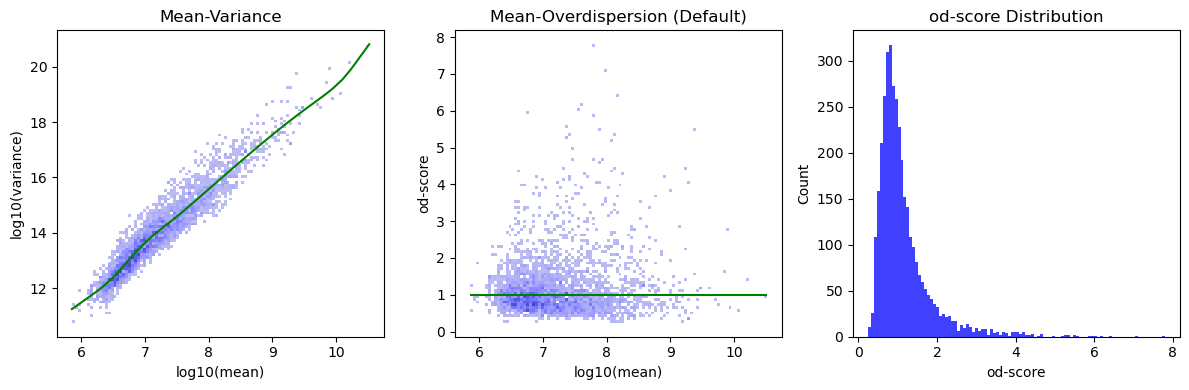

In [8]:
figs = cn.plot_feature_dispersion(diamandis, show_selected=False)

## Selecting overdispersed genes

2023-02-27 10:35:58,606 [INFO] 1612 genes selected for factorization


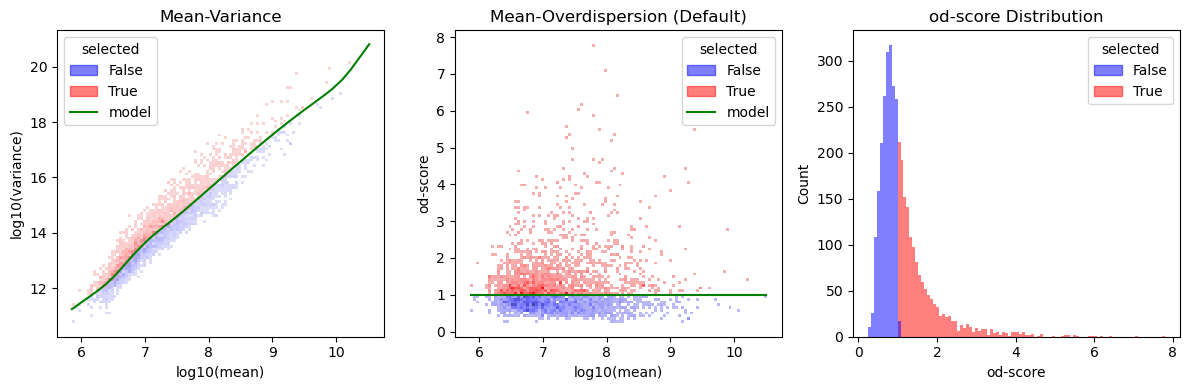

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"

# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=[2, 4, 6, 8], n_iter=10)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-02-27 10:36:02,963 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-02-27 10:36:02,964 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-02-27 10:36:02,965 [INFO] Creating consensus GEPs and usages for k=2
2023-02-27 10:36:04,784 [INFO] Creating consensus GEPs and usages for k=4
2023-02-27 10:36:06,884 [INFO] Creating consensus GEPs and usages for k=6
2023-02-27 10:36:08,953 [INFO] Creating consensus GEPs and usages for k=8
2023-02-27 10:36:15,932 [INFO] Importing GEPs: gene_spectra_score
2023-02-27 10:36:16,231 [INFO] Importing GEPs: gene_spectra_tpm
2023-02-27 10:36:16,533 [INFO] Importing GEPs: spectra
2023-02-27 10:36:16,669 [INFO] Importing Usages
2023-02-27 10:36:16,684 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-02-27 10:36:16,805 [INFO] Done


## Stability-Error Plot

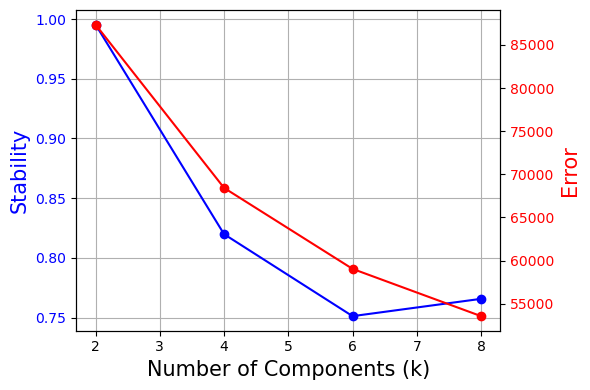

In [22]:
fig = cn.plot_stability_error(diamandis)

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

2023-02-27 10:56:31,409 [INFO] Choosing distinct colors for metadata layer patient_id
2023-02-27 10:56:31,612 [INFO] Choosing distinct colors for metadata layer simple_category
2023-02-27 10:56:31,635 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-02-27 10:56:31,658 [INFO] Choosing distinct colors for metadata layer sex
2023-02-27 10:56:31,667 [INFO] Choosing distinct colors for metadata layer location of resection
2023-02-27 10:56:31,776 [INFO] Choosing distinct colors for metadata layer ATRX
2023-02-27 10:56:31,786 [INFO] Choosing distinct colors for metadata layer p53
2023-02-27 10:56:31,800 [INFO] Choosing distinct colors for metadata layer MGMT


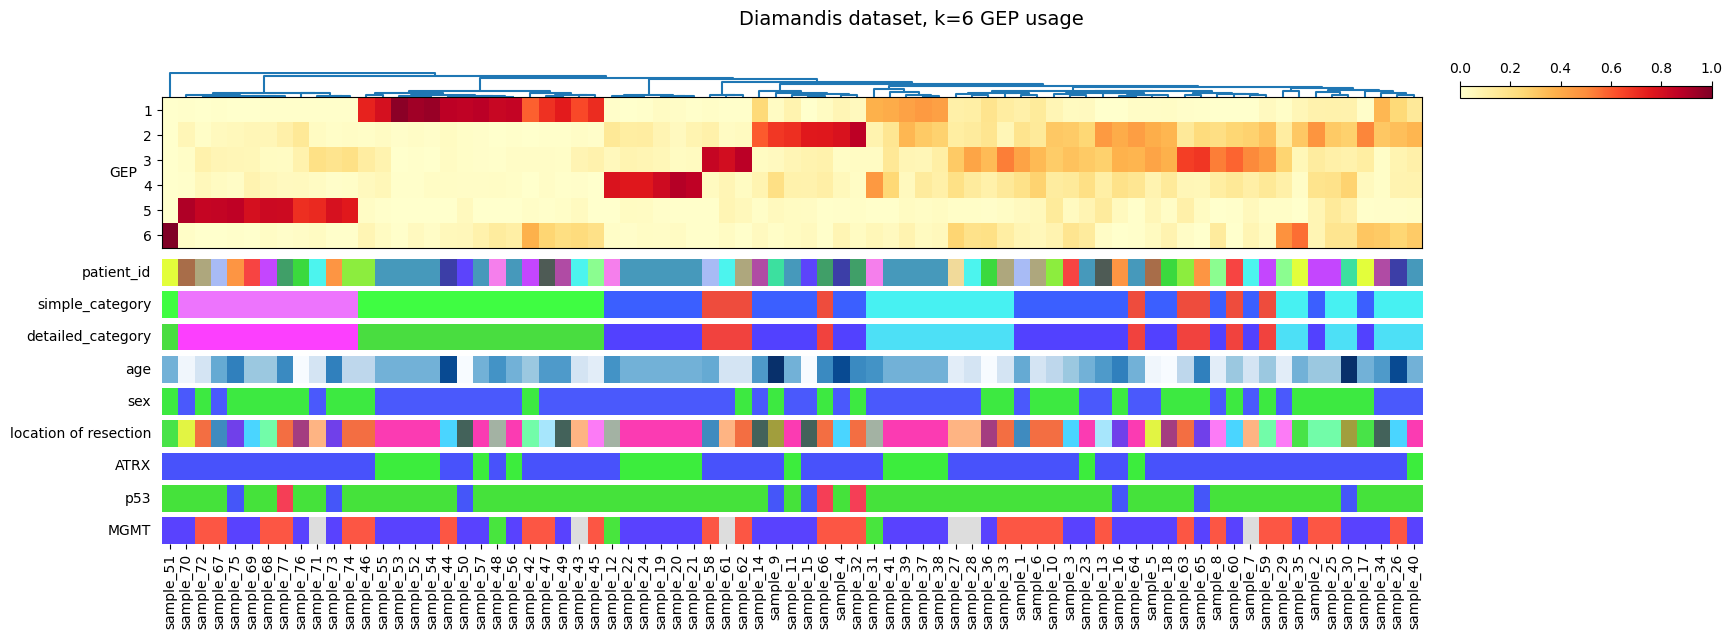

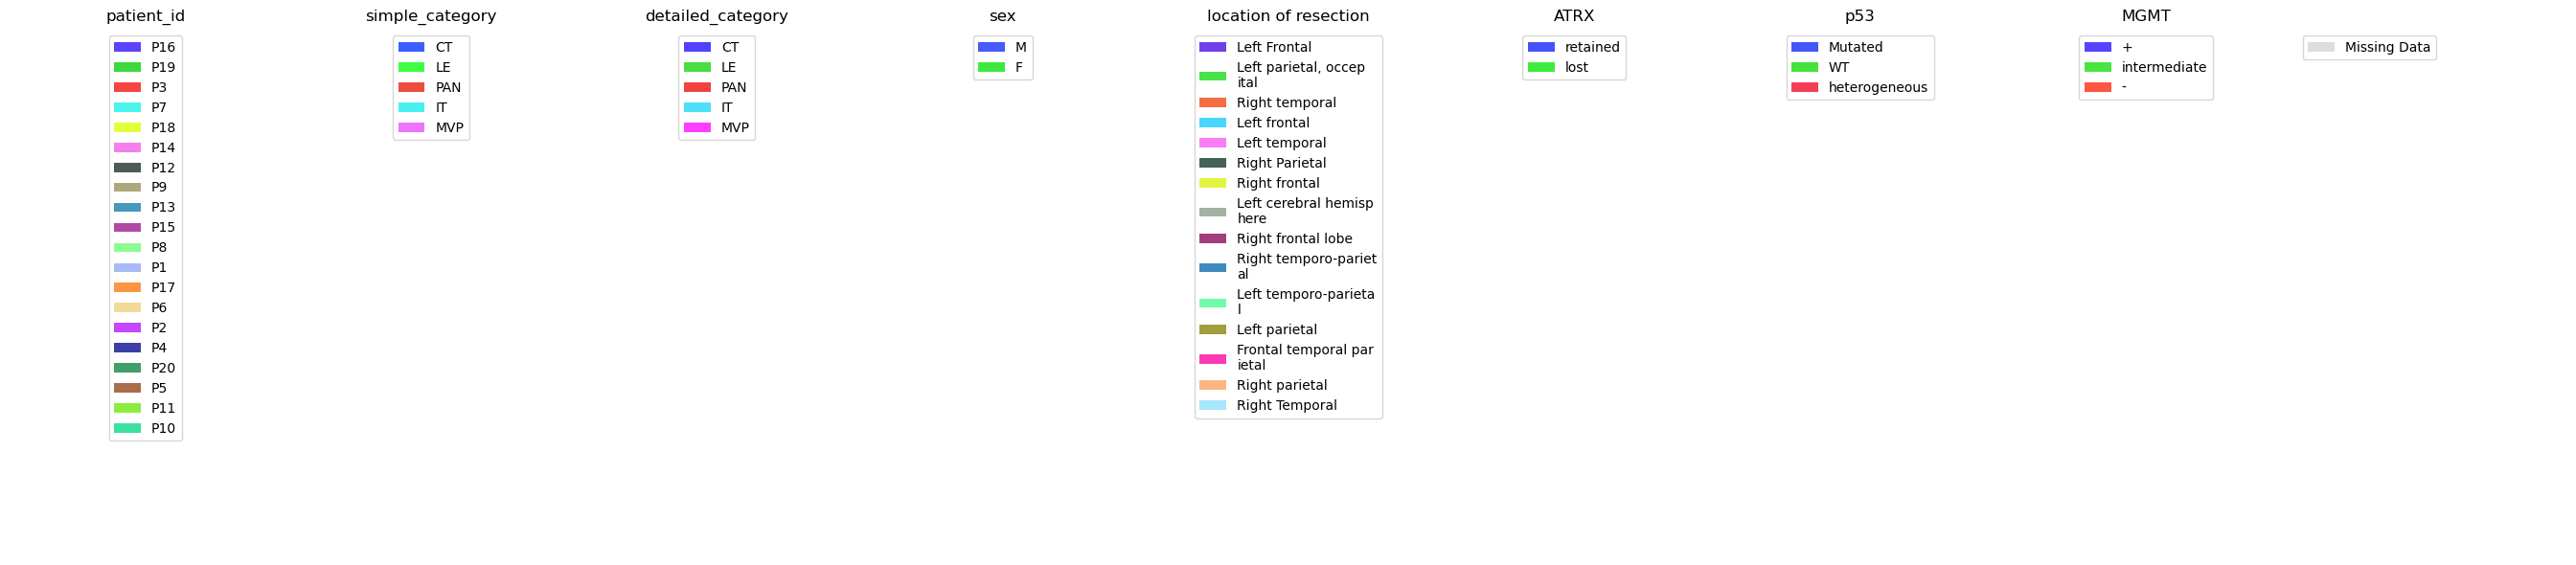

In [36]:
config = cn.Config()  # create empty configuration with default values
config.add_missing_metadata_colors(diamandis, pastel_factor=0.3)  # creates visually distinct colors for metadata tracks


fig = cn.plots.plot_annotated_usages(diamandis, k=6, metadata_colors=config.metadata_colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")
fig_legend = config.plot_metadata_colors_legend()
fig.savefig("metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [14]:

data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True)
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=[2, 4, 6, 8], n_iter=10)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

/home/tbverhey/github/cNMF-SNS/src/cnmfsns/dataset.py:108: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=data, var=var, uns=uns)
2023-02-27 10:36:22,174 [INFO] 4554 genes selected for factorization
2023-02-27 10:37:54,329 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-02-27 10:37:54,331 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-02-27 10:37:54,332 [INFO] Creating consensus GEPs and usages for k=2
2023-02-27 10:37:57,004 [INFO] Creating consensus GEPs and usages for k=4
2023-02-27 10:37:59,808 [INFO] Creating consensus GEPs and usages for k=6
2023-02-27 10:38:03,470 [INFO] Creating consensus GEPs and usages for k=8
2023-02-27 10:38:13,262 [INFO] Importing GEPs: gene_spectra_score
2023-02-27 10:38:14,463 [INFO]

## Integrate multiple datasets together

In [24]:
config = cn.Config.from_h5ad_files(["cptac.h5ad", "diamandis.h5ad"]) # first create an object to keep track of parameters
config.add_missing_dataset_colors()  # visually distinct colors for each dataset

integration = cn.Integration(config)  # create an integration object

2023-02-27 10:48:58,505 [INFO] Choosing distinct dataset colors
2023-02-27 10:48:58,729 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.


Identify whether the datasets had many/few overlapping genes

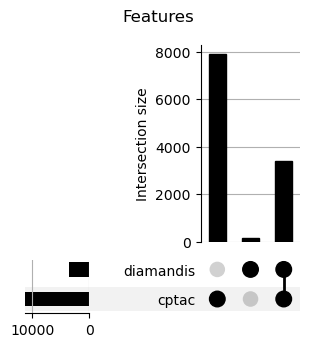

In [27]:
cn.plot_all_genes_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

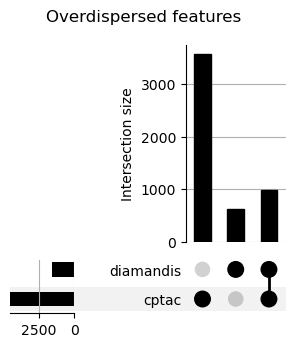

In [28]:
cn.plot_overdispersed_genes_upset(integration)

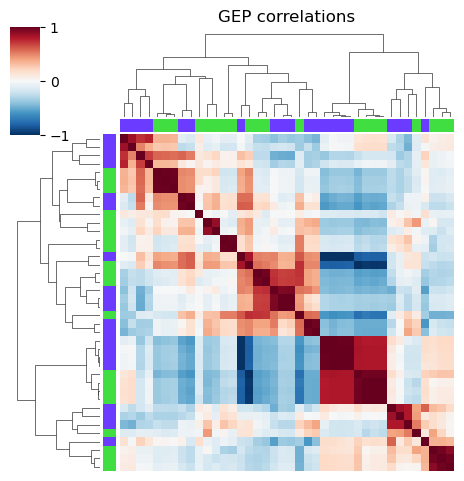

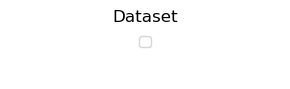

In [37]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plots.plot_correlation_matrix(integration, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = config.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [23]:
integration.k_table

cptac                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991594    297243.312500       True   
4        True              True         -0.289375    255125.906250       True   
6        True              True         -0.199004    231559.171875       True   
8        True              True         -0.156204    221186.718750       True   

              diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.990807        True              True         -0.999230     87362.820312   
4  0.734704        True              True         -0.265005     68426.484375   
6  0.670787        True              True         -0.165580     59036.640625   
8  0.470946        True              True         -0.119237     53557.453125   

                        
  selected_k stability  
2       True  0.995351  
4       True  0.819828  
6       True  0.751169  
8       True  0.765665

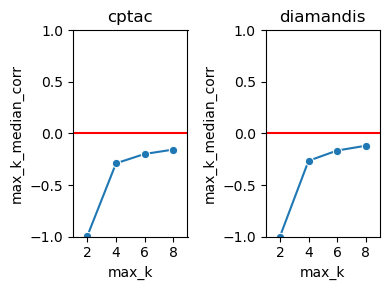

In [18]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

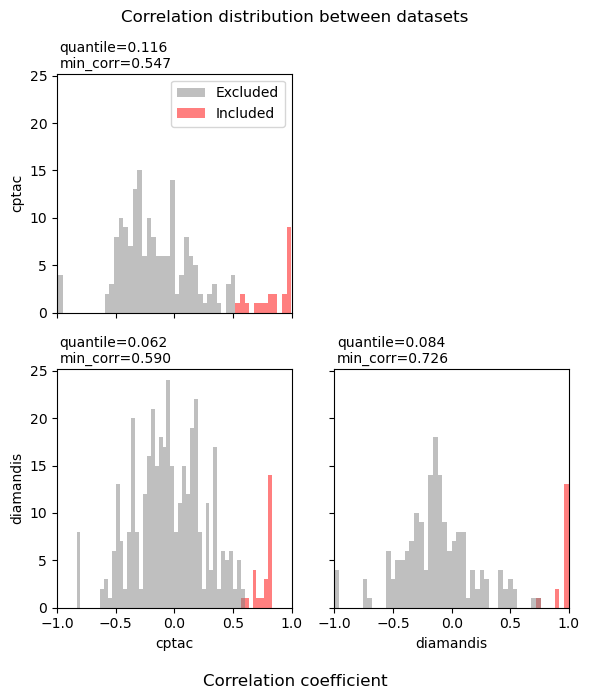

In [19]:
fig = cn.plot_pairwise_corr(integration)
# fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [20]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
cptac         20      20   20      20        20      20
diamandis     20      20   20      20        20      20

## Create an SNS map

In [41]:
import cnmfsns as cn

snsmap = cn.SNS(integration)  # create an SNS map for this integration

snsmap.integration.config.colormaps

{'diverging': 'RdBu_r', 'sequential': 'YlOrRd'}